In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [4]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [6]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [7]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [8]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
X_train = train[feature_names]

print(X_train.shape)

(10886, 10)


In [10]:
X_test = test[feature_names]

print(X_test.shape)

(6493, 10)


In [11]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [12]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313502


In [16]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780828


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012734,0.006839,0.008314,0.001420,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.012419,0.002496,0.005295,0.001496,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.011099,0.001293,0.006579,0.001003,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.012116,0.002001,0.003548,0.001205,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.011931,0.002326,0.005370,0.002554,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [18]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

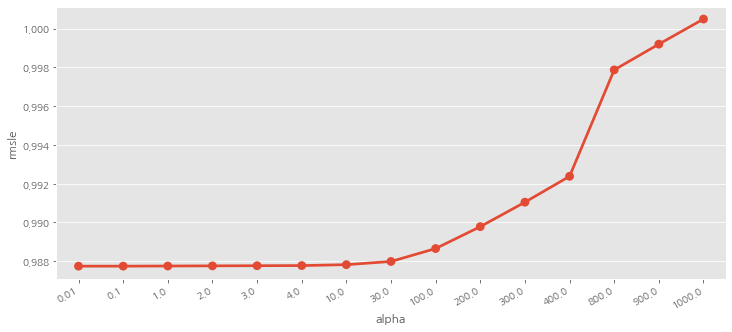

In [19]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [20]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457642


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

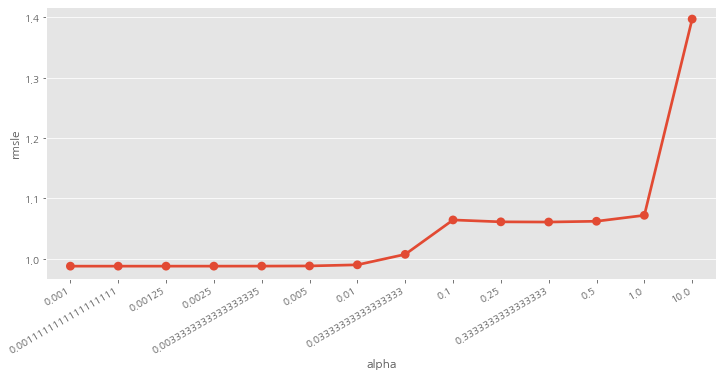

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor()

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10707367601047607


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21357403727840335


<AxesSubplot:ylabel='Density'>

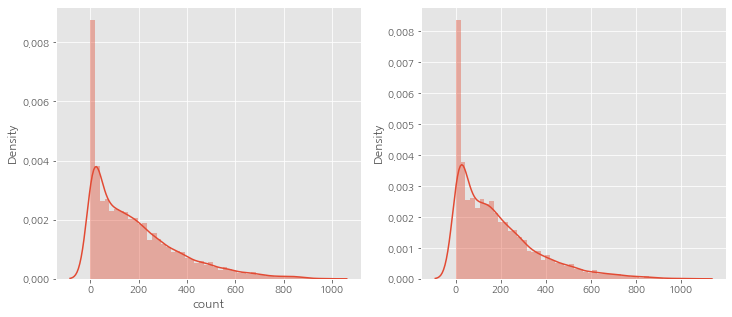

In [24]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

<AxesSubplot:ylabel='Density'>

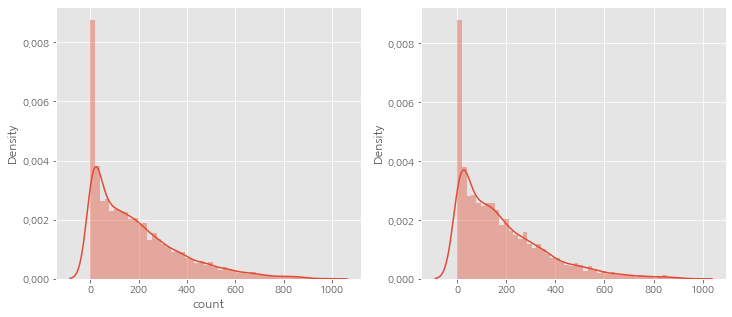

In [31]:
predsTest = rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [25]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

predsTest = rfModel.predict(X_test)
submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [26]:
submission.to_csv(f"data/Score_{score:.5f}_submission.csv", index=False)